In [11]:
# Data manipulation
import numpy as np
import pandas as pd

# Stock data retrieval
import yfinance as yf

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Time series splitting for walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Neural network portfolio optimizer and objective functions
from workflow.tools.models import LSTMPortfolioOptimizer
from workflow.tools.metrics import neg_sharpe_ratio, portfolio_risk

# Transaction costs
from workflow.tools.transaction_costs import net_tc

# Progress bar for loops
from tqdm.auto import tqdm

from workflow.tools.utils import set_plot_style, plot_allocations

set_plot_style()

In [2]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282078,44.861347,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487633,21.191519,45.184086,12.83,-0.000499,-0.004264,0.007168,-0.057548
2006-02-09,58.522655,21.390755,45.098011,13.12,0.000599,0.009358,-0.001907,0.022352
2006-02-10,58.399956,21.001337,45.191250,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440834,20.675314,44.986847,13.35,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Define lookback window
lookback = 50
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X[i-lookback] = features.iloc[i-lookback:i]

X.shape, y.shape

((4401, 50, 8), (4401, 4))

In [4]:
# Load empty optimizations dictionary
optimizations = {
    "MAX_SHARPE": {
        "OBJ": neg_sharpe_ratio,
        "METRIC_PROGRESSION": [],
        "WEIGHTS": [],
        "RETURNS": None
    },
    "MINIMUM_VARIANCE": {
        "OBJ": portfolio_risk,
        "METRIC_PROGRESSION": [],
        "WEIGHTS": [],
        "RETURNS": None
    }
}

# Define number of trading days per year and initialize TimeSeriesSplit
trading_days = 252
tss = TimeSeriesSplit(test_size=trading_days*2)

# Loop over optimization type
for i, (opt_type, params) in enumerate(optimizations.items()):

    print(f"-- {i+1}: {opt_type} --", end="\n")

    for e, (train_idx, test_idx) in enumerate(tss.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert inputs and targets to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Define input size, hidden size, and output size
        input_size = X_train.shape[-1]       # 8 features
        hidden_size = 64                     # 64 neurons
        output_size = y_train.shape[-1]      # 4 assets

        # Define number of training epochs
        epochs = 150

        # Instantiate model and optimizer
        model = LSTMPortfolioOptimizer(input_size, hidden_size, output_size)
        optimizer = torch.optim.Adam(model.parameters())

        # Construct training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            obj = params["OBJ"](outputs, y_train_tensor)
            obj.backward()
            optimizer.step()
            print(
                f"Split {e+1}: Epoch {epoch+1}/{epochs} ({(epoch+1)/epochs*100:,.2f}%)",
                "|",
                f"{obj.item():,.4f}" ,
                end="\r"
            )

        print()
        
        # Get the outputs (asset allocations) after training
        with torch.no_grad():
            model_allocations = model(X_test_tensor)
            optimizations[opt_type]["WEIGHTS"].append(model_allocations)
    
    print()

-- 1: MAX_SHARPE --
Split 1: Epoch 150/150 (100.00%) | -0.2006
Split 2: Epoch 150/150 (100.00%) | -0.2295
Split 3: Epoch 150/150 (100.00%) | -0.2156
Split 4: Epoch 150/150 (100.00%) | -0.2177
Split 5: Epoch 150/150 (100.00%) | -0.2049

-- 2: MINIMUM_VARIANCE --
Split 1: Epoch 150/150 (100.00%) | 0.0026
Split 2: Epoch 150/150 (100.00%) | 0.0024
Split 3: Epoch 150/150 (100.00%) | 0.0024
Split 4: Epoch 150/150 (100.00%) | 0.0022
Split 5: Epoch 150/150 (100.00%) | 0.0023



In [7]:
# Initialize empty list for dataframe concatenation
optimized_returns = []

# Compute the returns for each optimized portfolio
for opt_type, params in optimizations.items():
    weights = np.concatenate(params["WEIGHTS"])

    # Reindex features to match weights
    reindexed_features = features.iloc[-len(weights):]
    weights = pd.DataFrame(weights, index=reindexed_features.index, columns=indices)

    # Shift weights for real time information lag
    weights = weights.shift().dropna()

    reindexed_returns = reindexed_features[return_cols][1:]
    reindexed_returns.columns = indices

    # Portfolio returns = sum of (weights * returns)
    returns = (weights * reindexed_returns).sum(axis=1)
    returns = net_tc(returns, weights, cost_rate=0.005)
    returns.name = opt_type

    params["WEIGHTS"] = weights
    params["RETURNS"] = returns
    optimized_returns.append(returns)

# Concatenate optimized returns
optimized_returns = pd.concat(optimized_returns, axis=1)
optimized_returns.loc[optimized_returns.index.min()] = 0

optimized_returns.head()

,MAX_SHARPE,MINIMUM_VARIANCE
Date,,
2013-10-10,0.000000,0.000000
2013-10-11,0.003460,0.000783
2013-10-14,0.004955,-0.000290
2013-10-15,0.016617,0.000283
2013-10-16,-0.024425,0.002598


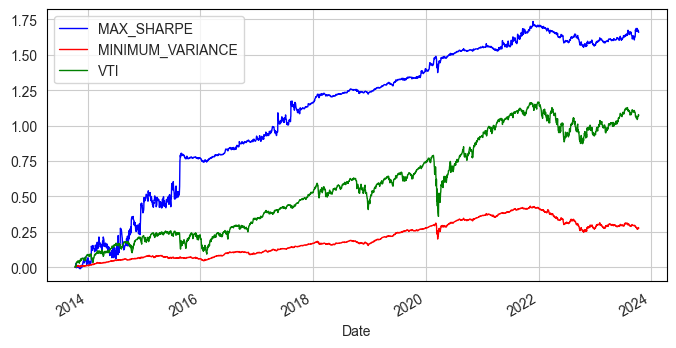

In [24]:
market_rets = features["STOCKS_RET"].reindex(optimized_returns.index)
market_rets.name = "VTI"
market_rets.loc[market_rets.index.min()] = 0

backtest = pd.concat([optimized_returns, market_rets], axis=1)

backtest.cumsum().plot(figsize=(8, 4), color=["b", "r", "g"])
plt.show()

In [27]:
optimized_stats = PortfolioStats(backtest, log=True)
optimized_stats.info.sort_values(by="SHARPE", ascending=False)

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
MAX_SHARPE,0.840967,1.657294,0.165795,0.197148,-0.181978
VTI,0.597574,1.069277,0.10697,0.179007,-0.430787
MINIMUM_VARIANCE,0.584122,0.273893,0.0274,0.046908,-0.184917


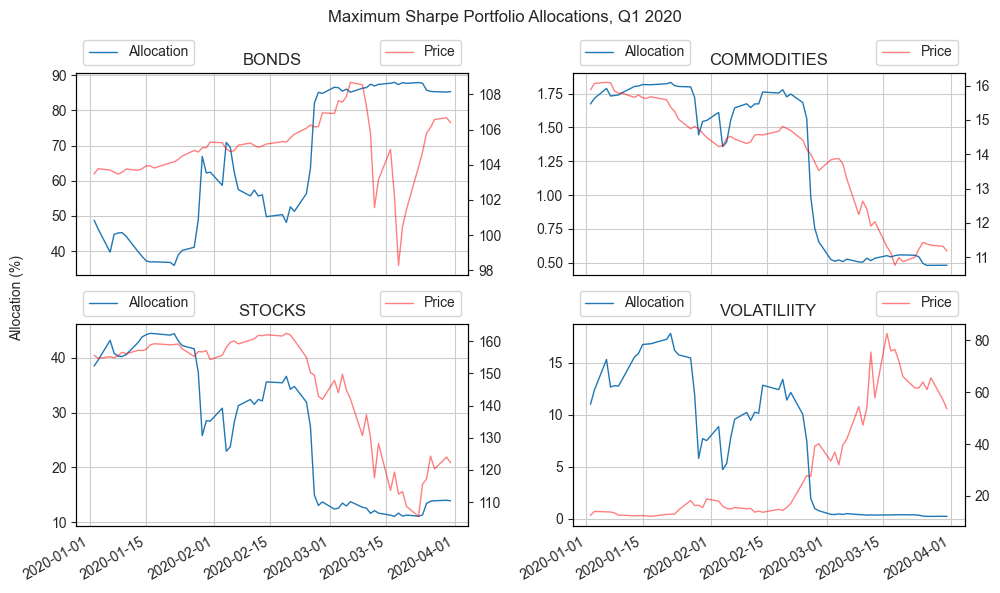

In [35]:
covid_q1 = {"start": "2020-01", "end": "2020-03"}

title = "Maximum Sharpe Portfolio Allocations, Q1 2020"
plot_allocations(optimizations["MAX_SHARPE"], features, indices, covid_q1, title)

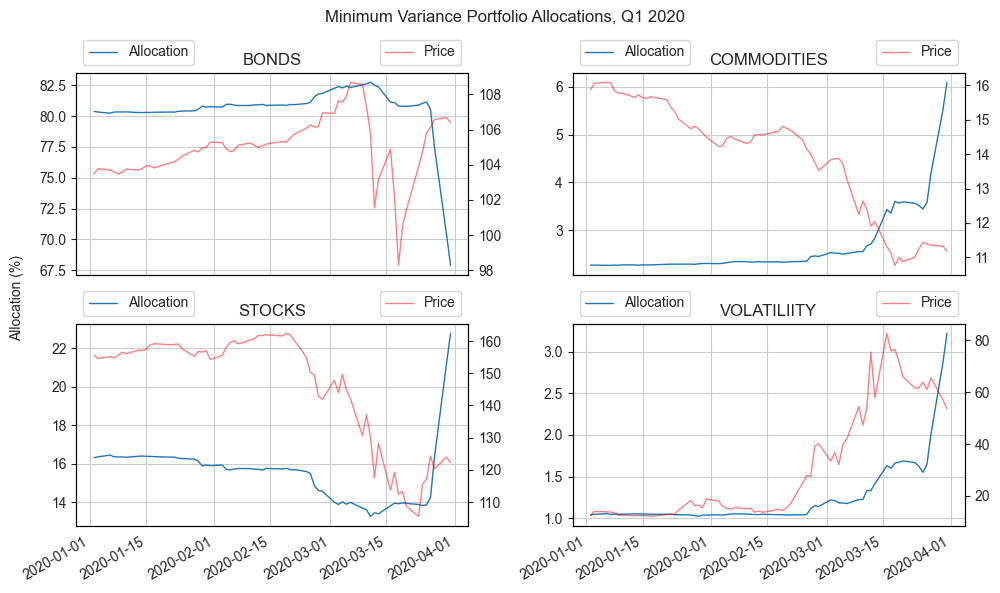

In [22]:
title = "Minimum Variance Portfolio Allocations, Q1 2020"
plot_allocations(optimizations["MINIMUM_VARIANCE"], features, indices, covid_q1, title)